In [1]:
!pip install scikit-learn imbalanced-learn xgboost
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install imbalanced-learn scikit-learn pandas numpy matplotlib seaborn

Looking in indexes: https://download.pytorch.org/whl/cu118


## Imports 

In [2]:
import pyarrow.orc as orc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')

In [3]:
# 1. Define the file path
path = r'spend_analysis_final.orc'

# 2. Load the file using PyArrow first (more efficient)
orc_file = orc.ORCFile(path)
table = orc_file.read()

# 3. Convert to Pandas with "self_destruct"
# self_destruct=True: Frees the Arrow memory AS it creates the Pandas DF
# split_blocks=True: Allows data to be scattered in RAM (doesn't need one giant 4GB block)
df = table.to_pandas(split_blocks=True, self_destruct=True)

print(df.head())
print(df.info()) # Check memory usage

     txn_date  year  month   age_group    income_tier user_gender  card_brand  \
0  2008-05-11  2008      5  Millennial  Middle_Income      Female  Mastercard   
1  2007-08-27  2007      8  Millennial  Middle_Income      Female  Mastercard   
2  2009-02-22  2009      2  Millennial  Middle_Income      Female  Mastercard   
3  2007-09-18  2007      9  Millennial  Middle_Income      Female  Mastercard   
4  2009-03-11  2009      3  Millennial  Middle_Income      Female  Mastercard   

  card_type spend_location_type   mcc total_spend_amount  transaction_count  \
0     Debit      Online/Unknown  4121             111.20                  5   
1     Debit      Online/Unknown  7801              84.09                  1   
2     Debit      Online/Unknown  4121              95.42                  6   
3     Debit     Travel_Domestic  7802             106.66                  1   
4     Debit      Online/Unknown  4814             139.15                  1   

  avg_ticket_size fraud_spend_amount m

##  MCC to Category Mapping

In [4]:


def map_mcc_to_category(mcc_code):
    """
    Maps MCC codes to lifestyle/merchant categories.
    Based on standard credit card MCC classifications.
    """
    mcc = int(mcc_code) if pd.notna(mcc_code) else 0
    
    # Transportation & Travel
    if 3000 <= mcc <= 3299:  # Airlines
        return 'Travel_Airlines'
    elif 3500 <= mcc <= 3999:  # Car Rental, Hotels
        return 'Travel_Lodging'
    elif 4000 <= mcc <= 4799:  # Transportation Services
        return 'Travel_Transport'
    elif 7800 <= mcc <= 7899:  # Entertainment (includes travel agencies)
        return 'Travel_Entertainment'
    
    # Retail & Shopping
    elif 5000 <= mcc <= 5099:  # Wholesale Clubs
        return 'Retail_Wholesale'
    elif 5200 <= mcc <= 5299:  # Discount Stores
        return 'Retail_Discount'
    elif 5300 <= mcc <= 5399:  # Department Stores
        return 'Retail_Department'
    elif 5400 <= mcc <= 5499:  # Grocery Stores
        return 'Retail_Groceries'
    elif 5500 <= mcc <= 5599:  # Automotive
        return 'Retail_Automotive'
    elif 5600 <= mcc <= 5699:  # Clothing Stores
        return 'Retail_Clothing'
    elif 5700 <= mcc <= 5799:  # Miscellaneous Stores
        return 'Retail_Misc'
    elif 5800 <= mcc <= 5899:  # Restaurants
        return 'Dining_Restaurants'
    elif 5900 <= mcc <= 5999:  # Drug Stores, Pharmacies
        return 'Retail_Pharmacy'
    
    # Services
    elif 6000 <= mcc <= 6099:  # Financial Services
        return 'Services_Financial'
    elif 6100 <= mcc <= 6199:  # Insurance
        return 'Services_Insurance'
    elif 6200 <= mcc <= 6299:  # Real Estate
        return 'Services_RealEstate'
    elif 6300 <= mcc <= 6399:  # Utilities
        return 'Services_Utilities'
    elif 6400 <= mcc <= 6499:  # Professional Services
        return 'Services_Professional'
    
    # Healthcare & Education
    elif 8000 <= mcc <= 8099:  # Medical Services
        return 'Healthcare_Medical'
    elif 8200 <= mcc <= 8299:  # Schools, Educational
        return 'Education'
    
    # Technology & Communication
    elif 4814 == mcc:  # Telecommunications
        return 'Tech_Telecom'
    elif 4812 == mcc:  # Computer Network Services
        return 'Tech_Internet'
    elif 4816 == mcc:  # Computer Network/Information Services
        return 'Tech_Internet'
    
    # Entertainment & Recreation
    elif 7800 <= mcc <= 7829:  # Motion Picture Theaters
        return 'Entertainment_Movies'
    elif 7830 <= mcc <= 7839:  # Video Rental
        return 'Entertainment_Video'
    elif 7840 <= mcc <= 7849:  # Video Game Arcades
        return 'Entertainment_Gaming'
    elif 7850 <= mcc <= 7859:  # Record Stores
        return 'Entertainment_Music'
    elif 7910 <= mcc <= 7919:  # Dance Halls, Studios, Schools
        return 'Entertainment_Dance'
    elif 7920 <= mcc <= 7929:  # Theatrical Producers
        return 'Entertainment_Theater'
    elif 7930 <= mcc <= 7939:  # Bowling Alleys
        return 'Entertainment_Bowling'
    elif 7940 <= mcc <= 7999:  # Commercial Sports, Recreation
        return 'Entertainment_Sports'
    
    # Gas Stations
    elif 5541 == mcc or 5542 == mcc:  # Gas Stations
        return 'Automotive_Gas'
    
    # Government & Utilities
    elif 9000 <= mcc <= 9999:  # Government Services
        return 'Government'
    
    else:
        return 'Other_Unknown'

# Apply MCC mapping
if 'mcc' in df.columns:
    df['MCC_Category'] = df['mcc'].apply(map_mcc_to_category)
    print(f"MCC Categories Mapped: {df['MCC_Category'].nunique()} unique categories")
    print(f"   Top Categories: {df['MCC_Category'].value_counts().head(10).to_dict()}")
else:
    print("MCC column not found in dataframe")
    df['MCC_Category'] = 'Other_Unknown'

MCC Categories Mapped: 20 unique categories
   Top Categories: {'Other_Unknown': 1744364, 'Dining_Restaurants': 1335398, 'Retail_Groceries': 1208637, 'Retail_Department': 1194561, 'Travel_Transport': 1072252, 'Retail_Pharmacy': 1029544, 'Retail_Automotive': 533689, 'Tech_Telecom': 290776, 'Retail_Discount': 272532, 'Travel_Entertainment': 222172}


## Create User-Level MCC Spending Profile

In [5]:

# Convert total_spend_amount to numeric
df['total_spend_amount'] = pd.to_numeric(df['total_spend_amount'], errors='coerce').fillna(0)

# Create a user identifier (if not exists, use index)
if 'user_id' not in df.columns:
    # Try to infer user identifier from available columns
    user_id_cols = ['user_gender', 'age_group', 'income_tier']
    if all(col in df.columns for col in user_id_cols):
        df['user_id'] = df[user_id_cols].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    else:
        df['user_id'] = df.index.astype(str)

# Aggregate spending by user and MCC category
mcc_spending = df.groupby(['user_id', 'MCC_Category'])['total_spend_amount'].sum().reset_index()

# Pivot to get spending by category for each user
mcc_pivot = mcc_spending.pivot_table(
    index='user_id',
    columns='MCC_Category',
    values='total_spend_amount',
    fill_value=0
)

# Calculate total spending per user
mcc_pivot['Total_Spend'] = mcc_pivot.sum(axis=1)

# Calculate percentage of spending by category
mcc_percentages = mcc_pivot.div(mcc_pivot['Total_Spend'], axis=0) * 100
mcc_percentages = mcc_percentages.drop(columns=['Total_Spend'])

print(f"\n✅ User-Level MCC Profiles Created: {len(mcc_pivot)} users")
print(f"   Categories Analyzed: {len(mcc_pivot.columns) - 1}")


✅ User-Level MCC Profiles Created: 24 users
   Categories Analyzed: 20


## Lifestyle Segmentation Based on Spending Patterns

In [8]:
def assign_lifestyle_segment(row):
    """
    Assigns lifestyle segment based on dominant spending categories.
    """
    # Define lifestyle rules
    travel_spend = row.get('Travel_Airlines', 0) + row.get('Travel_Lodging', 0) + row.get('Travel_Transport', 0)
    retail_spend = row.get('Retail_Groceries', 0) + row.get('Retail_Department', 0) + row.get('Retail_Clothing', 0)
    dining_spend = row.get('Dining_Restaurants', 0)
    entertainment_spend = row.get('Entertainment_Movies', 0) + row.get('Entertainment_Sports', 0) + row.get('Entertainment_Gaming', 0)
    tech_spend = row.get('Tech_Telecom', 0) + row.get('Tech_Internet', 0)
    
    # Lifestyle classification
    if travel_spend > 30:
        return 'Frequent_Traveler'
    elif retail_spend > 40:
        return 'Retail_Shopper'
    elif dining_spend > 25:
        return 'Foodie'
    elif entertainment_spend > 20:
        return 'Entertainment_Enthusiast'
    elif tech_spend > 15:
        return 'Tech_Savvy'
    elif row.get('Retail_Groceries', 0) > 30:
        return 'Home_Focused'
    elif row.get('Services_Financial', 0) + row.get('Services_Insurance', 0) > 20:
        return 'Financial_Conscious'
    else:
        return 'Balanced_Lifestyle'

# Assign lifestyle segments
mcc_pivot['Lifestyle_Segment'] = mcc_percentages.apply(assign_lifestyle_segment, axis=1)

print(f"\nLifestyle Segments Assigned")
print(f"   Segment Distribution:")
print(mcc_pivot['Lifestyle_Segment'].value_counts())


Lifestyle Segments Assigned
   Segment Distribution:
Lifestyle_Segment
Balanced_Lifestyle    23
Frequent_Traveler      1
Name: count, dtype: int64


## Aggregate Analysis by Segment

In [10]:
segment_analysis = mcc_percentages.groupby(mcc_pivot['Lifestyle_Segment']).mean().T
segment_analysis = segment_analysis.sort_values(by=segment_analysis.columns[0], ascending=False)

print("\n" + "="*80)
print("AVERAGE SPENDING PERCENTAGE BY LIFESTYLE SEGMENT")
print("="*80)
print(segment_analysis.round(2))


AVERAGE SPENDING PERCENTAGE BY LIFESTYLE SEGMENT
Lifestyle_Segment      Balanced_Lifestyle  Frequent_Traveler
MCC_Category                                                
Other_Unknown                       23.75              28.27
Retail_Department                   12.93               7.35
Travel_Transport                    10.16              32.89
Retail_Groceries                     9.51               4.45
Retail_Pharmacy                      7.53               4.49
Dining_Restaurants                   7.36               2.36
Retail_Automotive                    5.03               2.03
Tech_Telecom                         4.49               9.41
Travel_Airlines                      3.38               1.00
Healthcare_Medical                   3.12               3.56
Services_Utilities                   2.77               0.07
Travel_Lodging                       2.18               0.55
Retail_Discount                      1.75               0.57
Travel_Entertainment               

## Visualization

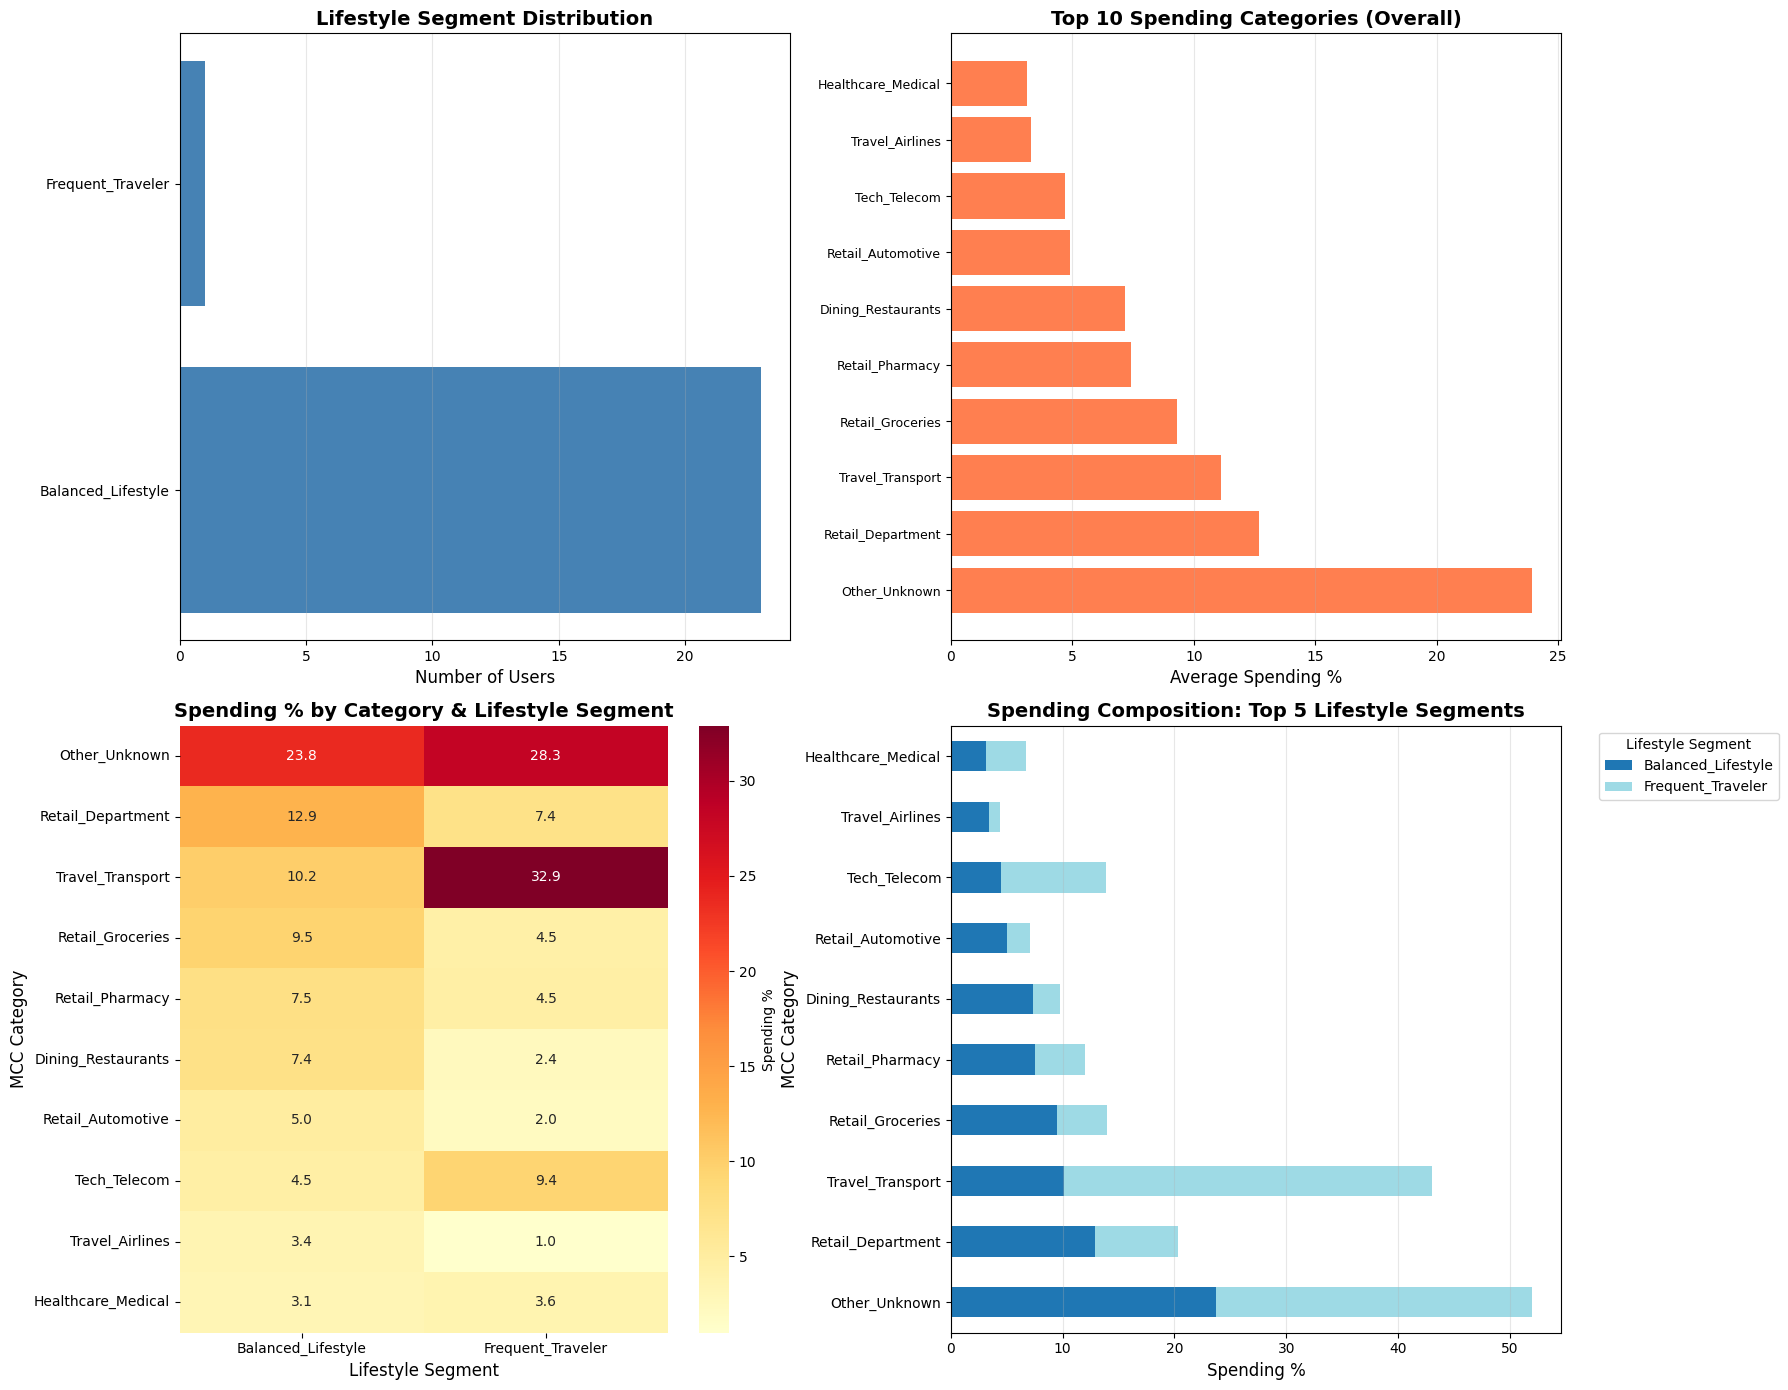

In [11]:
# 1. Top Categories by Lifestyle Segment
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Lifestyle Segment Distribution
ax1 = axes[0, 0]
lifestyle_counts = mcc_pivot['Lifestyle_Segment'].value_counts()
ax1.barh(lifestyle_counts.index, lifestyle_counts.values, color='steelblue')
ax1.set_xlabel('Number of Users', fontsize=12)
ax1.set_title('Lifestyle Segment Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Top Spending Categories (Overall)
ax2 = axes[0, 1]
top_categories = mcc_percentages.mean().nlargest(10)
ax2.barh(range(len(top_categories)), top_categories.values, color='coral')
ax2.set_yticks(range(len(top_categories)))
ax2.set_yticklabels(top_categories.index, fontsize=9)
ax2.set_xlabel('Average Spending %', fontsize=12)
ax2.set_title('Top 10 Spending Categories (Overall)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Heatmap of Top Categories by Segment
ax3 = axes[1, 0]
top_10_cats = mcc_percentages.mean().nlargest(10).index
heatmap_data = segment_analysis.loc[top_10_cats]
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax3, cbar_kws={'label': 'Spending %'})
ax3.set_title('Spending % by Category & Lifestyle Segment', fontsize=14, fontweight='bold')
ax3.set_xlabel('Lifestyle Segment', fontsize=12)
ax3.set_ylabel('MCC Category', fontsize=12)

# Plot 4: Stacked Bar Chart - Top Segments
ax4 = axes[1, 1]
top_segments = mcc_pivot['Lifestyle_Segment'].value_counts().head(5).index
stacked_data = segment_analysis[top_segments].loc[top_10_cats]
stacked_data.plot(kind='barh', stacked=True, ax=ax4, colormap='tab20')
ax4.set_title('Spending Composition: Top 5 Lifestyle Segments', fontsize=14, fontweight='bold')
ax4.set_xlabel('Spending %', fontsize=12)
ax4.set_ylabel('MCC Category', fontsize=12)
ax4.legend(title='Lifestyle Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## Detailed Segment Profiles

In [12]:
## print("\n" + "="*80)
print("DETAILED LIFESTYLE SEGMENT PROFILES")
print("="*80)

for segment in mcc_pivot['Lifestyle_Segment'].unique():
    segment_users = mcc_pivot[mcc_pivot['Lifestyle_Segment'] == segment]
    segment_spending = mcc_percentages.loc[segment_users.index].mean()
    top_5_cats = segment_spending.nlargest(5)
    
    print(f"\n{'─'*80}")
    print(f"Segment: {segment} (n={len(segment_users)} users)")
    print(f"{'─'*80}")
    print("Top 5 Spending Categories:")
    for cat, pct in top_5_cats.items():
        print(f"  • {cat}: {pct:.2f}%")
    print(f"\nAverage Total Spend: ${segment_users['Total_Spend'].mean():,.2f}")


DETAILED LIFESTYLE SEGMENT PROFILES

────────────────────────────────────────────────────────────────────────────────
Segment: Balanced_Lifestyle (n=23 users)
────────────────────────────────────────────────────────────────────────────────
Top 5 Spending Categories:
  • Other_Unknown: 23.75%
  • Retail_Department: 12.93%
  • Travel_Transport: 10.16%
  • Retail_Groceries: 9.51%
  • Retail_Pharmacy: 7.53%

Average Total Spend: $46,256,809.86

────────────────────────────────────────────────────────────────────────────────
Segment: Frequent_Traveler (n=1 users)
────────────────────────────────────────────────────────────────────────────────
Top 5 Spending Categories:
  • Travel_Transport: 32.89%
  • Other_Unknown: 28.27%
  • Tech_Telecom: 9.41%
  • Retail_Department: 7.35%
  • Retail_Pharmacy: 4.49%

Average Total Spend: $191,490.27


## Export Key Metrics

In [13]:
# Create summary dataframe
summary_df = pd.DataFrame({
    'User_ID': mcc_pivot.index,
    'Lifestyle_Segment': mcc_pivot['Lifestyle_Segment'],
    'Total_Spend': mcc_pivot['Total_Spend']
})

# Add top 3 categories for each user
for idx, row in mcc_percentages.iterrows():
    top_3 = row.nlargest(3)
    summary_df.loc[summary_df['User_ID'] == idx, 'Top_Category_1'] = top_3.index[0]
    summary_df.loc[summary_df['User_ID'] == idx, 'Top_Category_1_Pct'] = top_3.iloc[0]
    if len(top_3) > 1:
        summary_df.loc[summary_df['User_ID'] == idx, 'Top_Category_2'] = top_3.index[1]
        summary_df.loc[summary_df['User_ID'] == idx, 'Top_Category_2_Pct'] = top_3.iloc[1]
    if len(top_3) > 2:
        summary_df.loc[summary_df['User_ID'] == idx, 'Top_Category_3'] = top_3.index[2]
        summary_df.loc[summary_df['User_ID'] == idx, 'Top_Category_3_Pct'] = top_3.iloc[2]

print("\n" + "="*80)
print("ANALYSIS COMPLETE")


ANALYSIS COMPLETE


## MCC-Based Spending Forecasting (Functions)

In [14]:
print("\n" + "="*80)
print("MCC-BASED SPENDING FORECASTING")
print("="*80)

def forecast_with_models(cat_data, method='ensemble'):
    """
    Forecast using multiple models and ensemble
    methods: 'linear', 'moving_avg', 'exponential', 'ensemble'
    """
    period_nums = np.array(range(len(cat_data))).reshape(-1, 1)
    amounts = cat_data['total_spend_amount'].values

    forecasts = {}

    # Model 1: Linear Regression
    if len(amounts) >= 2:
        lr_model = LinearRegression()
        lr_model.fit(period_nums, amounts)
        next_period = len(cat_data)
        forecasts['linear'] = max(0, lr_model.predict([[next_period]])[0])

    # Model 2: Moving Average (last N periods)
    if len(amounts) >= 3:
        window = min(3, len(amounts))
        forecasts['moving_avg'] = amounts[-window:].mean()

    # Model 3: Exponential Weighted Average (recent periods weighted more)
    if len(amounts) >= 2:
        weights = np.exp(np.linspace(-1, 0, len(amounts)))
        weights = weights / weights.sum()
        forecasts['exponential'] = np.average(amounts, weights=weights)

    # Model 4: Trend-adjusted (linear + recent momentum)
    if len(amounts) >= 3:
        recent_trend = (amounts[-1] - amounts[-2]) if len(amounts) >= 2 else 0
        forecasts['trend_adjusted'] = amounts[-1] + recent_trend

    # Ensemble: Average of all models
    if forecasts:
        if method == 'ensemble':
            return np.mean(list(forecasts.values())), forecasts
        else:
            return forecasts.get(method, amounts[-1] if len(amounts) > 0 else 0), forecasts

    return amounts[-1] if len(amounts) > 0 else 0, {}

print("Forecasting Functions Defined")


MCC-BASED SPENDING FORECASTING
Forecasting Functions Defined


## Execution of Forecasting

In [15]:
# Use enhanced forecasting
print("\nUsing Enhanced Multi-Model Forecasting...")

# Check if we have date information for time-based forecasting
has_date = 'txn_date' in df.columns or 'year' in df.columns or 'month' in df.columns
user_forecasts_list = []
forecast_df = pd.DataFrame()

if has_date:
    # Time-based forecasting approach
    print("\nUsing Time-Based Forecasting...")
    
    # Prepare time series data
    if 'txn_date' in df.columns:
        df['txn_date'] = pd.to_datetime(df['txn_date'], errors='coerce')
        df['year_month'] = df['txn_date'].dt.to_period('M')
    elif 'year' in df.columns and 'month' in df.columns:
        df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)
    
    # Aggregate spending by user, category, and time period
    time_mcc_spending = df.groupby(['user_id', 'MCC_Category', 'year_month'])['total_spend_amount'].sum().reset_index()
    
    # Create forecasting for each user-category combination
    forecasts = []
    
    for user_id in df['user_id'].unique()[:100]:  # Limit to first 100 users for performance
        user_data = time_mcc_spending[time_mcc_spending['user_id'] == user_id]
        
        for category in user_data['MCC_Category'].unique():
            cat_data = user_data[user_data['MCC_Category'] == category].sort_values('year_month')
            
            if len(cat_data) >= 3:  # Need at least 3 data points
                # Convert period to numeric for regression
                cat_data = cat_data.copy()
                cat_data['period_num'] = range(len(cat_data))
                
                # Enhanced multi-model forecasting
                forecast, model_forecasts = forecast_with_models(cat_data, method='ensemble')
            
                # Calculate trend from linear model
                if 'linear' in model_forecasts:
                    lr_model = LinearRegression()
                    period_nums = np.array(range(len(cat_data))).reshape(-1, 1)
                    lr_model.fit(period_nums, cat_data['total_spend_amount'].values)
                    trend = lr_model.coef_[0] if len(lr_model.coef_) > 0 else 0
                else:
                    trend = (cat_data['total_spend_amount'].iloc[-1] - cat_data['total_spend_amount'].iloc[-2]) if len(cat_data) >= 2 else 0
            
                forecasts.append({
                    'user_id': user_id,
                    'MCC_Category': category,
                    'last_spend': cat_data['total_spend_amount'].iloc[-1],
                    'forecast_spend': forecast,
                    'trend': trend,
                    'historical_avg': cat_data['total_spend_amount'].mean()
                })
    
    forecast_df = pd.DataFrame(forecasts)
    
else:
    # Pattern-based forecasting (without time series)
    print("\nUsing Pattern-Based Forecasting (Average + Trend Estimation)...")
    
    # Use historical averages and lifestyle patterns for forecasting
    for user_id in mcc_pivot.index[:100]:  # Limit for performance
        user_segment = mcc_pivot.loc[user_id, 'Lifestyle_Segment']
        user_total = mcc_pivot.loc[user_id, 'Total_Spend']
        
        # Get segment averages for categories
        segment_avg_pct = segment_analysis[user_segment] if user_segment in segment_analysis.columns else mcc_percentages.mean()
        
        # Forecast: Use segment patterns + user's total spend trend
        forecast_by_category = {}
        for category in mcc_percentages.columns:
            if category in segment_avg_pct.index:
                category_pct = segment_avg_pct[category]
                forecast_amount = (category_pct / 100) * user_total * 1.05  # 5% growth assumption
                forecast_by_category[category] = forecast_amount
        
        user_forecasts_list.append({
            'user_id': user_id,
            'lifestyle_segment': user_segment,
            'current_total': user_total,
            'forecasted_total': user_total * 1.05,
            'forecast_by_category': forecast_by_category
        })
    
    forecast_summary = pd.DataFrame(user_forecasts_list)
    
    # Flatten for DF structure
    all_category_forecasts = []
    for _, row in forecast_summary.iterrows():
        for cat, amount in row['forecast_by_category'].items():
            all_category_forecasts.append({
                'user_id': row['user_id'],
                'MCC_Category': cat,
                'forecast_spend': amount,
                'last_spend': (mcc_pivot.loc[row['user_id'], cat] if cat in mcc_pivot.columns else 0),
                'trend': 0
            })
    forecast_df = pd.DataFrame(all_category_forecasts)

print(f"Generated forecasts for {len(forecast_df)} combinations")


Using Enhanced Multi-Model Forecasting...

Using Time-Based Forecasting...
Generated forecasts for 465 combinations


## Summary & Vizualization


CATEGORY-LEVEL FORECASTS
      MCC_Category  forecast_spend  last_spend      trend  forecast_change_pct
     Other_Unknown    1.515467e+06  1643298.13 432.781484            -7.778958
 Retail_Department    8.507925e+05   926509.04 313.183038            -8.172235
  Retail_Groceries    6.284903e+05   683942.64 198.949541            -8.107738
  Travel_Transport    6.225645e+05   679418.56 210.406565            -8.368027
Dining_Restaurants    5.312314e+05   598196.16 203.216729           -11.194436
   Retail_Pharmacy    5.041900e+05   551183.31 165.795984            -8.525888
 Retail_Automotive    3.371109e+05   367518.79  97.600631            -8.273805
      Tech_Telecom    2.757557e+05   300967.07  57.148107            -8.376765
Healthcare_Medical    2.183492e+05   236665.15  45.502330            -7.739136
   Travel_Airlines    1.447059e+05   103876.49  55.042412            39.305364


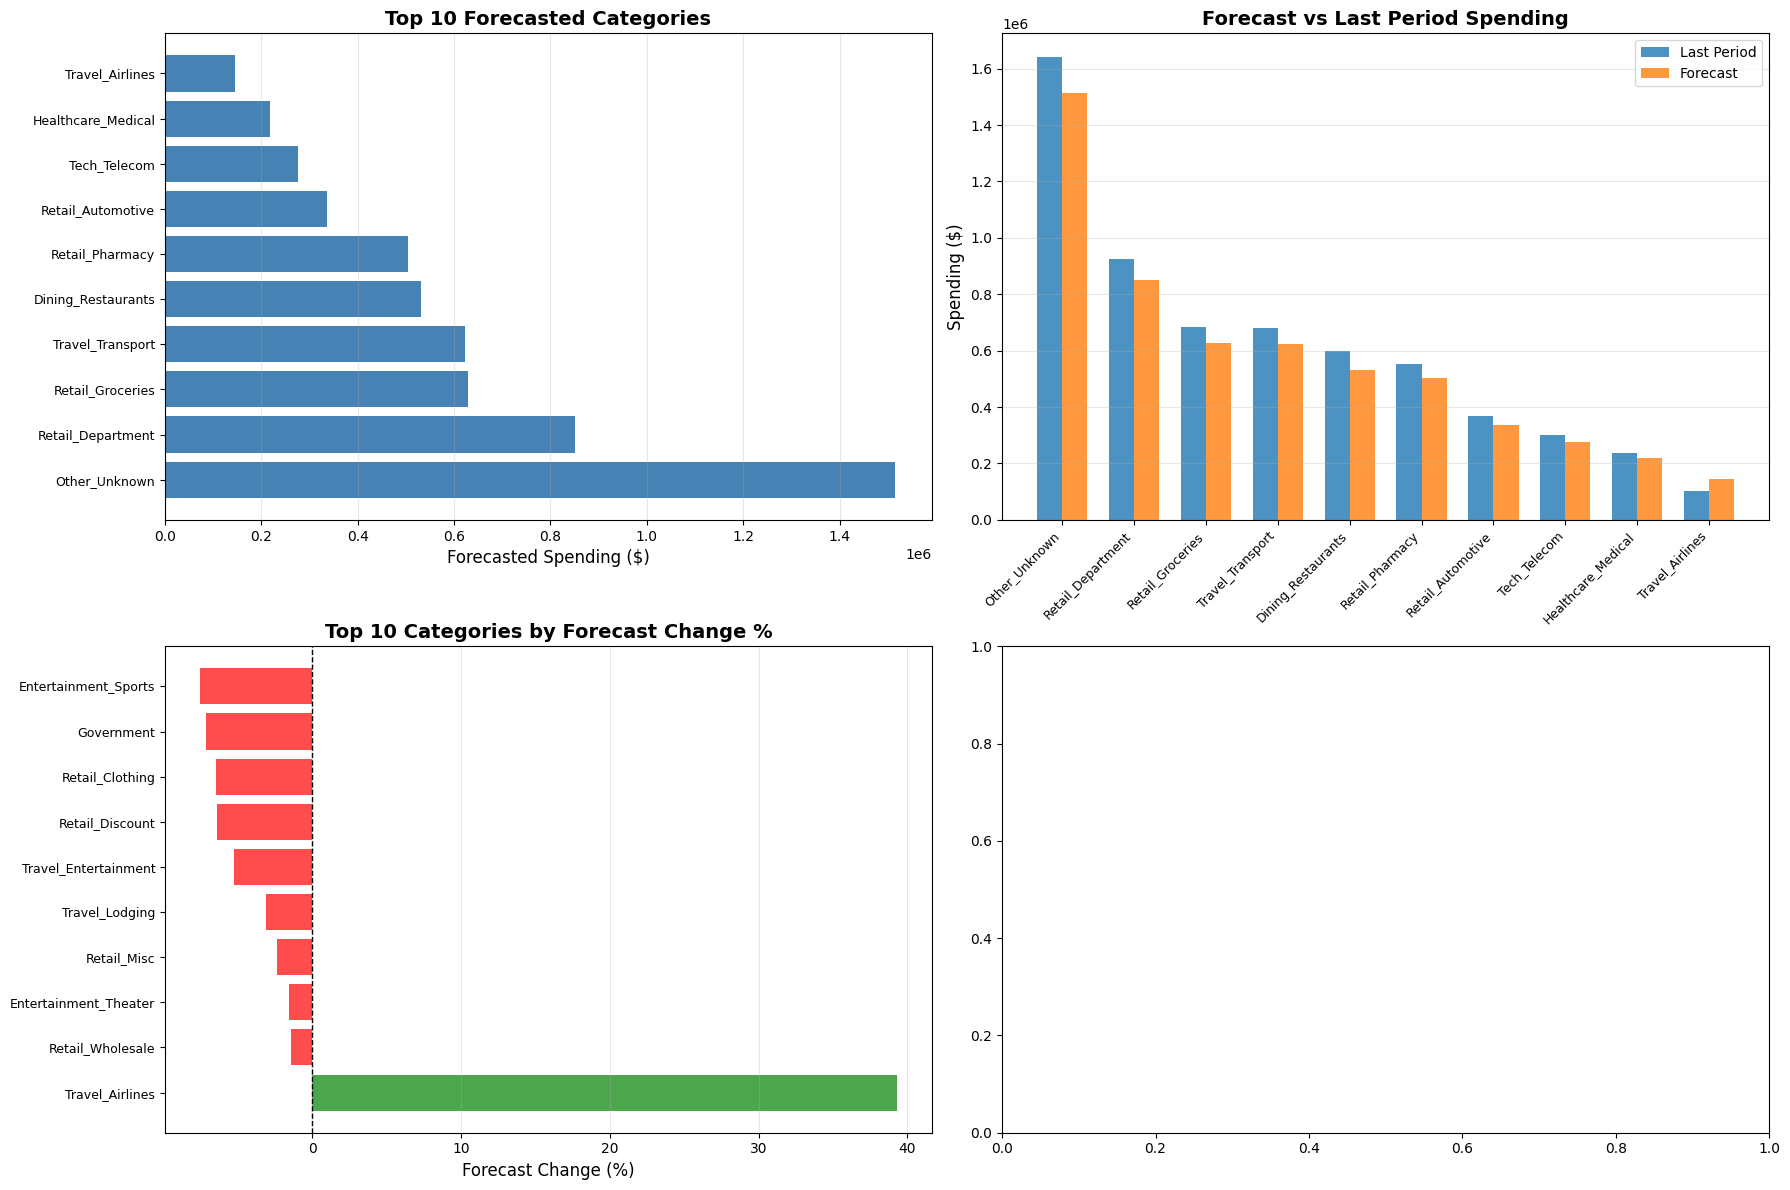


FORECASTING COMPLETE


In [16]:
if len(forecast_df) > 0:
    # Aggregate forecasts by category
    category_forecasts = forecast_df.groupby('MCC_Category').agg({
        'forecast_spend': 'sum',
        'last_spend': 'sum',
        'trend': 'mean'
    }).reset_index()
    category_forecasts['forecast_change_pct'] = ((category_forecasts['forecast_spend'] - category_forecasts['last_spend']) / 
                                                (category_forecasts['last_spend'] + 1)) * 100
    
    print("\n" + "="*80)
    print("CATEGORY-LEVEL FORECASTS")
    print("="*80)
    print(category_forecasts.sort_values('forecast_spend', ascending=False).head(10).to_string(index=False))
    
    # Visualize forecasts
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot 1: Top forecasted categories
    ax1 = axes[0, 0]
    top_forecasts = category_forecasts.nlargest(10, 'forecast_spend')
    ax1.barh(range(len(top_forecasts)), top_forecasts['forecast_spend'].values, color='steelblue')
    ax1.set_yticks(range(len(top_forecasts)))
    ax1.set_yticklabels(top_forecasts['MCC_Category'].values, fontsize=9)
    ax1.set_xlabel('Forecasted Spending ($)', fontsize=12)
    ax1.set_title('Top 10 Forecasted Categories', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot 2: Forecast vs Last Period
    ax2 = axes[0, 1]
    top_10_cats = category_forecasts.nlargest(10, 'forecast_spend')
    x_pos = np.arange(len(top_10_cats))
    width = 0.35
    ax2.bar(x_pos - width/2, top_10_cats['last_spend'].values, width, label='Last Period', alpha=0.8)
    ax2.bar(x_pos + width/2, top_10_cats['forecast_spend'].values, width, label='Forecast', alpha=0.8)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(top_10_cats['MCC_Category'].values, rotation=45, ha='right', fontsize=9)
    ax2.set_ylabel('Spending ($)', fontsize=12)
    ax2.set_title('Forecast vs Last Period Spending', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # Plot 3: Forecast Change Percentage
    ax3 = axes[1, 0]
    top_changes = category_forecasts.nlargest(10, 'forecast_change_pct')
    colors = ['green' if x > 0 else 'red' for x in top_changes['forecast_change_pct'].values]
    ax3.barh(range(len(top_changes)), top_changes['forecast_change_pct'].values, color=colors, alpha=0.7)
    ax3.set_yticks(range(len(top_changes)))
    ax3.set_yticklabels(top_changes['MCC_Category'].values, fontsize=9)
    ax3.set_xlabel('Forecast Change (%)', fontsize=12)
    ax3.set_title('Top 10 Categories by Forecast Change %', fontsize=14, fontweight='bold')
    ax3.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax3.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("FORECASTING COMPLETE")

## BEST MODEL

## Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, mean_absolute_error, classification_report


## Mock Data Generation (Transaction Level)

In [18]:
# We simulate raw transactions to demonstrate the pivot logic
np.random.seed(42)
n_txns = 10000
n_users = 500

data = {
    'user_id': np.random.randint(0, n_users, n_txns),
    'amount': np.random.exponential(50, n_txns),
    'mcc': np.random.choice([
        3000, 3500, # Travel (Airlines, Hotels)
        5411, 5812, # Food (Groceries, Restaurants)
        5541, 4814, # Utilities (Gas, Telecom)
        5311, 5999  # Retail (Dept Stores, Misc)
    ], n_txns),
    'txn_date': pd.date_range(start='2024-01-01', periods=n_txns).tolist()
}
df = pd.DataFrame(data)

## MCC Mapping & Pivot Logic (The Core)

In [19]:
print("Transforming Transaction Data...")

def map_mcc(code):
    if 3000 <= code <= 3999: return 'Travel'
    if 5400 <= code <= 5499: return 'Groceries'
    if 5800 <= code <= 5899: return 'Dining'
    if 5500 <= code <= 5599: return 'Transport'
    if 4800 <= code <= 4999: return 'Utilities'
    return 'Retail'

df['Category'] = df['mcc'].apply(map_mcc)

# Pivot: Rows = Users, Cols = Categories, Values = Total Amount
user_profile = df.pivot_table(
    index='user_id', 
    columns='Category', 
    values='amount', 
    aggfunc='sum', 
    fill_value=0
)

# Feature Engineering: Wallet Share (%)
# We care about % of spend, not just raw totals, to find "Lifestyle"
user_profile['Total_Spend'] = user_profile.sum(axis=1)
wallet_share = user_profile.div(user_profile['Total_Spend'], axis=0).iloc[:, :-1] # Drop Total col

print(f"User Profiles Created: {user_profile.shape[0]} Users")
print(wallet_share.head(3))

Transforming Transaction Data...
User Profiles Created: 500 Users
Category    Dining  Groceries    Retail  Transport    Travel  Utilities
user_id                                                                
0         0.081516   0.133905  0.095890   0.388252  0.105486   0.194951
1         0.230136   0.087321  0.428562   0.022428  0.216546   0.015007
2         0.182450   0.073803  0.123299   0.332123  0.116416   0.171910


## Model A: Lifestyle Segmentation (Unsupervised)


 Running Lifestyle Segmentation (K-Means)...
   Silhouette Score: 0.202 (Higher is better)

--- Lifestyle Cluster Profiles (Avg Wallet Share) ---
Category      Dining   Groceries      Retail   Transport      Travel  \
Cluster                                                                
0          94.337000  127.900364  402.703578   85.346000  189.856982   
1          89.096165  133.132373  188.287271  274.488184  197.605823   
2         281.871307  102.085429  182.146266   88.619378  195.432856   
3          86.503739  124.650862  188.547812   83.846510  384.838199   

Category   Utilities  
Cluster               
0         117.306133  
1         113.596814  
2         113.902537  
3         140.841442  


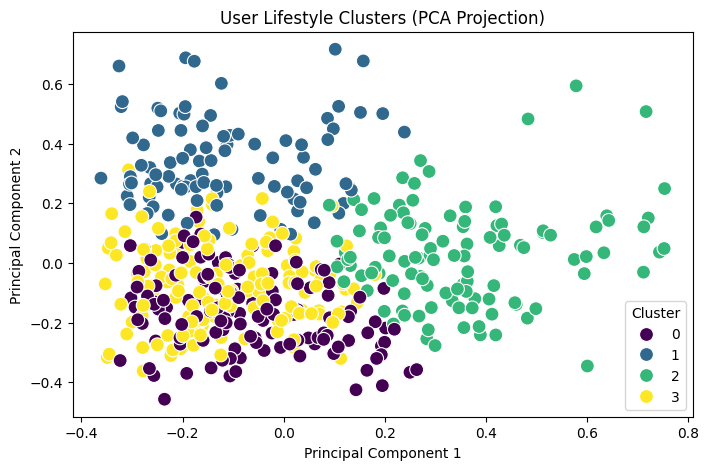

In [20]:
print("\n Running Lifestyle Segmentation (K-Means)...")

# Scale features (Percent data is already 0-1, but scaling helps KMeans)
scaler = MinMaxScaler()
X_cluster = scaler.fit_transform(wallet_share)

# Fit K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
user_profile['Cluster'] = kmeans.fit_predict(X_cluster)

# Evaluate
sil_score = silhouette_score(X_cluster, user_profile['Cluster'])
print(f"   Silhouette Score: {sil_score:.3f} (Higher is better)")

# Interpret Clusters
cluster_summary = user_profile.groupby('Cluster')[wallet_share.columns].mean()
print("\n--- Lifestyle Cluster Profiles (Avg Wallet Share) ---")
print(cluster_summary)

# Visualize Clusters (PCA)
pca = PCA(n_components=2)
coords = pca.fit_transform(X_cluster)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=user_profile['Cluster'], palette='viridis', s=100)
plt.title('User Lifestyle Clusters (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Model B: Merchant Affinity Prediction (Supervised)

In [21]:
print("\nTraining Merchant Affinity Model...")

# Goal: Predict if a user is a "High Value Diner" (Top 33% of Dining spenders)
# This helps us target them for Dining Rewards Cards.

dining_threshold = user_profile['Dining'].quantile(0.67)
user_profile['Is_High_Value_Diner'] = (user_profile['Dining'] > dining_threshold).astype(int)

# Features: All OTHER spending habits (excluding Dining itself to prevent leakage)
X_affinity = wallet_share.drop(columns=['Dining'])
y_affinity = user_profile['Is_High_Value_Diner']

X_train, X_test, y_train, y_test = train_test_split(X_affinity, y_affinity, test_size=0.2, random_state=42)

# Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("\n--- Affinity Model Performance ---")
print(classification_report(y_test, y_pred, target_names=['Standard', 'High Value']))

# Feature Importance
importances = pd.Series(clf.feature_importances_, index=X_affinity.columns)
print("\n--- Top Predictors of Dining Affinity ---")
print(importances.sort_values(ascending=False))



Training Merchant Affinity Model...

--- Affinity Model Performance ---
              precision    recall  f1-score   support

    Standard       0.85      0.95      0.90        73
  High Value       0.79      0.56      0.65        27

    accuracy                           0.84       100
   macro avg       0.82      0.75      0.77       100
weighted avg       0.84      0.84      0.83       100


--- Top Predictors of Dining Affinity ---
Category
Travel       0.236272
Retail       0.217727
Transport    0.191247
Utilities    0.184546
Groceries    0.170208
dtype: float64


## Business Output

In [22]:
# We map the cluster numbers to business names for the final report
cluster_names = {
    0: 'The Traveler (High Travel Share)',
    1: 'The Homebody (High Grocery/Utility)',
    2: 'The Socialite (High Dining)',
    3: 'The Shopper (High Retail)'
    # Note: These names are examples; check the 'Cluster Profiles' printout to name them accurately
}
user_profile['Lifestyle_Label'] = user_profile['Cluster'].map(cluster_names).fillna('Mixed')

print("\nFinal Data Ready for Export:")
print(user_profile[['Total_Spend', 'Lifestyle_Label', 'Is_High_Value_Diner']].head())


Final Data Ready for Export:
Category  Total_Spend                      Lifestyle_Label  \
user_id                                                      
0         1013.854838  The Homebody (High Grocery/Utility)   
1          868.264378     The Traveler (High Travel Share)   
2          701.132872  The Homebody (High Grocery/Utility)   
3          769.939903            The Shopper (High Retail)   
4         1244.203440            The Shopper (High Retail)   

Category  Is_High_Value_Diner  
user_id                        
0                           0  
1                           1  
2                           0  
3                           0  
4                           0  


In [24]:
# Join Cluster labels to the Wallet Share (Percentage) Dataframe
wallet_share['Cluster'] = user_profile['Cluster']

# Group by Cluster to see the AVERAGE PERCENTAGE spend
true_lifestyle_profile = wallet_share.groupby('Cluster').mean()

print("\nCORRECTED Lifestyle Profiles (Values are % of Wallet):")
# Multiply by 100 for readability (e.g., 0.45 -> 45%)
print((true_lifestyle_profile * 100).round(1).astype(str) + '%')

# Now you can name them accurately:
# If Cluster 0 has 'Travel': 55%, name it "The Jetsetter"


CORRECTED Lifestyle Profiles (Values are % of Wallet):
Category Dining Groceries Retail Transport Travel Utilities
Cluster                                                    
0          9.2%     12.8%  40.0%      8.2%  18.3%     11.4%
1          9.0%     13.8%  18.6%     28.0%  18.9%     11.6%
2         29.6%     10.6%  18.4%      9.6%  20.0%     11.9%
3          8.1%     12.4%  18.5%      8.1%  38.6%     14.3%


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Re-train with 'class_weight="balanced"'
# This penalizes missing the "High Value" users more
clf_balanced = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf_balanced.fit(X_train, y_train)

y_pred_balanced = clf_balanced.predict(X_test)

print("\nImproved Affinity Model (Balanced):")
print(classification_report(y_test, y_pred_balanced, target_names=['Standard', 'High Value']))


Improved Affinity Model (Balanced):
              precision    recall  f1-score   support

    Standard       0.86      0.95      0.90        73
  High Value       0.80      0.59      0.68        27

    accuracy                           0.85       100
   macro avg       0.83      0.77      0.79       100
weighted avg       0.85      0.85      0.84       100

